# Transfer learning and fine-tuning

- Learn how to classify images of cats and dogs by using transfer learning from a pre-trained network
- Practice two ways to customize a pre-trained model: **feature extraction** and **fine-tuning**
- Full tutorial reference: https://www.tensorflow.org/tutorials/images/transfer_learning
- Additional fine-tuning guide: https://www.tensorflow.org/guide/keras/transfer_learning

### Import TensorFlow and necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.9.1


### Data preprocessing
- download the dataset
- configure the dataset for performance
- data augmentation
- rescale pixel values

In [2]:
dataset_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=dataset_url, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [3]:
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'validation')

In [4]:
batch_size = 32
img_size = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    image_size=img_size
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    batch_size=batch_size,
    image_size=img_size
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [5]:
class_names = train_dataset.class_names
print(class_names)

['cats', 'dogs']


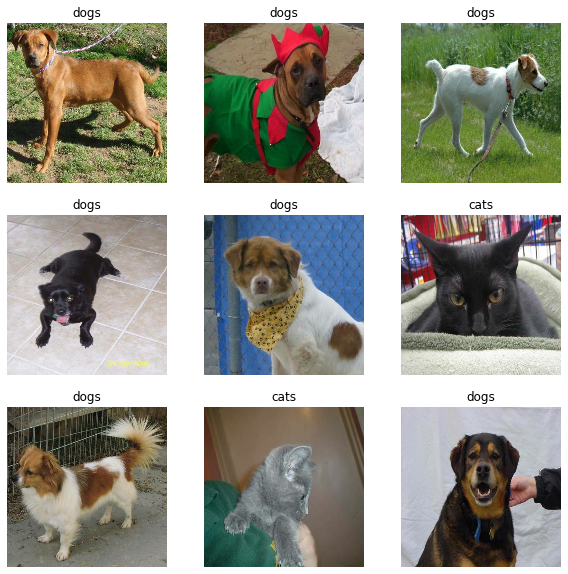

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

plt.show()

In [6]:
val_batches = tf.data.experimental.cardinality(val_dataset)
print(val_batches.numpy())

32


In [7]:
# create a test set
test_dataset = val_dataset.take(val_batches // 5)
val_dataset = val_dataset.skip(val_batches // 5)
print('Number of validation and test batches: {}, {}.'.format(
    tf.data.experimental.cardinality(val_dataset).numpy(), tf.data.experimental.cardinality(test_dataset).numpy()))

Number of validation and test batches: 26, 6.


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

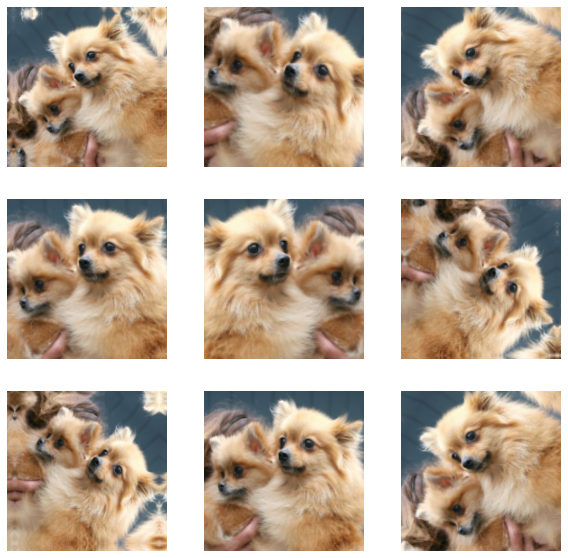

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        augmented_images = data_augmentation(images)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

plt.show()

In [10]:
# rescale pixel values from [0, 255] to [-1, 1] when using the MobileNetV2 model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### Create the base model from the pre-trained convnets

In [11]:
img_shape = img_size + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_shape,
    include_top=False, # does not include the classification layers at the top
    weights='imagenet'
)

In [12]:
# feature extractor converts each (160, 160, 3) image into a (5, 5, 1280) block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Feature extraction
- Freeze the convolutional base model and to use as a **feature extractor**
- add a classifier on top of it and train the top-level classifier

In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
# Keras functional API
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [18]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # since there are binary (two) classes
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

### Train the model

In [20]:
epochs = 10

initial_eval = model.evaluate(val_dataset)

26/26 [==============================] - 9s 273ms/step - loss: 0.7560 - accuracy: 0.5285


In [21]:
print('initial loss and accuracy: {:.2f}, {:.2f}'.format(initial_eval[0], initial_eval[1]))

initial loss and accuracy: 0.76, 0.53


In [22]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/10
63/63 [==============================] - 31s 449ms/step - loss: 0.6733 - accuracy: 0.6320 - val_loss: 0.5160 - val_accuracy: 0.7017
Epoch 2/10
63/63 [==============================] - 29s 454ms/step - loss: 0.5132 - accuracy: 0.7260 - val_loss: 0.3902 - val_accuracy: 0.7809
Epoch 3/10
63/63 [==============================] - 30s 477ms/step - loss: 0.4298 - accuracy: 0.7810 - val_loss: 0.3116 - val_accuracy: 0.8230
Epoch 4/10
63/63 [==============================] - 40s 629ms/step - loss: 0.3939 - accuracy: 0.8020 - val_loss: 0.2570 - val_accuracy: 0.8725
Epoch 5/10
63/63 [==============================] - 32s 507ms/step - loss: 0.3418 - accuracy: 0.8365 - val_loss: 0.2212 - val_accuracy: 0.8973
Epoch 6/10
63/63 [==============================] - 34s 535ms/step - loss: 0.3061 - accuracy: 0.8515 - val_loss: 0.1957 - val_accuracy: 0.9146
Epoch 7/10
63/63 [==============================] - 35s 555ms/step - loss: 0.2761 - accuracy: 0.8755 - val_loss: 0.1679 - val_accuracy: 0.9270

### Visualize training results

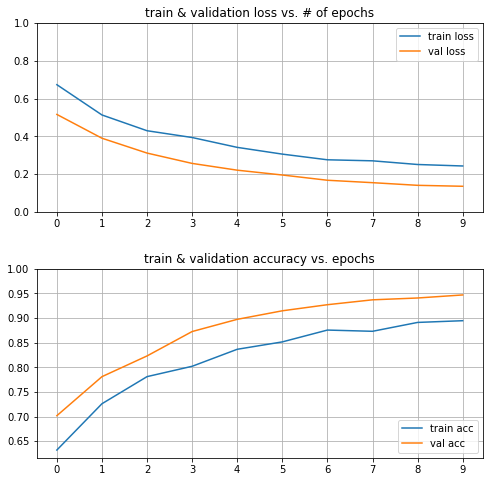

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

num_of_epochs = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.3)
plt.plot(num_of_epochs, loss, label='train loss')
plt.plot(num_of_epochs, val_loss, label='val loss')
plt.grid(True)
plt.xticks(num_of_epochs)
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('train & validation loss vs. # of epochs')

plt.subplot(2, 1, 2)
plt.plot(num_of_epochs, acc, label='train acc')
plt.plot(num_of_epochs, val_acc, label='val acc')
plt.grid(True)
plt.xticks(num_of_epochs)
plt.ylim([min(plt.ylim()), 1])
plt.legend(loc='lower right')
plt.title('train & validation accuracy vs. epochs')

plt.show()

### Fine tuning
- In the feature extraction, only few layers (classifier) on top of the base pre-trained model were trained, and the weights of the pre-trained network were **not** updated during training.
- Fine-tuning comes from the idea that not only training the classifier, but also fine-tuning the weights of the top layers of the pre-trained network to enhance model's performance even better. 

### Un-freeze the top layers of the model

In [24]:
base_model.trainable = True

In [25]:
print('# of layers in the base model:', len(base_model.layers))

fine_tune_at = 100
for layer in base_model.layers[0:fine_tune_at]:
    layer.trainable = False

# of layers in the base model: 154


### Compile the model

In [26]:
model.compile(
    # it is critical to use very low learning rate, because you are training a much larger model.
    # if the learning rate (weights updates) is large, you are at risk of overfitting.
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

### Continue training the model

In [32]:
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

history_fine_tuned = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_dataset
)

Epoch 10/20
63/63 [==============================] - 40s 587ms/step - loss: 0.2022 - accuracy: 0.9100 - val_loss: 0.0685 - val_accuracy: 0.9777
Epoch 11/20
63/63 [==============================] - 41s 654ms/step - loss: 0.1421 - accuracy: 0.9390 - val_loss: 0.0583 - val_accuracy: 0.9715
Epoch 12/20
63/63 [==============================] - 46s 725ms/step - loss: 0.1329 - accuracy: 0.9415 - val_loss: 0.0444 - val_accuracy: 0.9814
Epoch 13/20
63/63 [==============================] - 49s 776ms/step - loss: 0.1098 - accuracy: 0.9535 - val_loss: 0.0429 - val_accuracy: 0.9851
Epoch 14/20
63/63 [==============================] - 48s 766ms/step - loss: 0.1157 - accuracy: 0.9555 - val_loss: 0.0382 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 47s 745ms/step - loss: 0.0982 - accuracy: 0.9590 - val_loss: 0.0409 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 46s 727ms/step - loss: 0.0900 - accuracy: 0.9650 - val_loss: 0.0349 - val_accuracy:

### Visualize training results after fine-tuning 

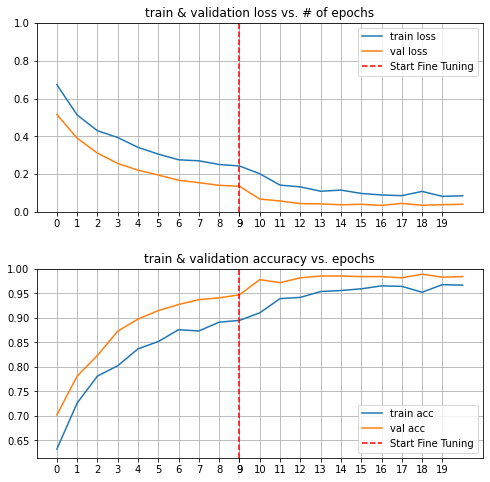

In [40]:
loss = history.history['loss'] + history_fine_tuned.history['loss']
val_loss = history.history['val_loss'] + history_fine_tuned.history['val_loss']

acc = history.history['accuracy'] + history_fine_tuned.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine_tuned.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.3)
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.axvline(x=9, color='r', ls='--', label='Start Fine Tuning')
plt.grid(True)
plt.xticks(num_of_epochs)
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('train & validation loss vs. # of epochs')

plt.subplot(2, 1, 2)
plt.plot(acc, label='train acc')
plt.plot(val_acc, label='val acc')
plt.axvline(x=9, color='r', ls='--', label='Start Fine Tuning')
plt.grid(True)
plt.xticks(num_of_epochs)
plt.ylim([min(plt.ylim()), 1])
plt.legend(loc='lower right')
plt.title('train & validation accuracy vs. epochs')

plt.show()

### Evaluation and prediction

In [42]:
test_eval = model.evaluate(test_dataset)
print('Test loss and accuracy: {:.2f}, {:.2f}'.format(test_eval[0], test_eval[1]))

6/6 [==============================] - 2s 283ms/step - loss: 0.0189 - accuracy: 0.9948
Test loss and accuracy: 0.02, 0.99


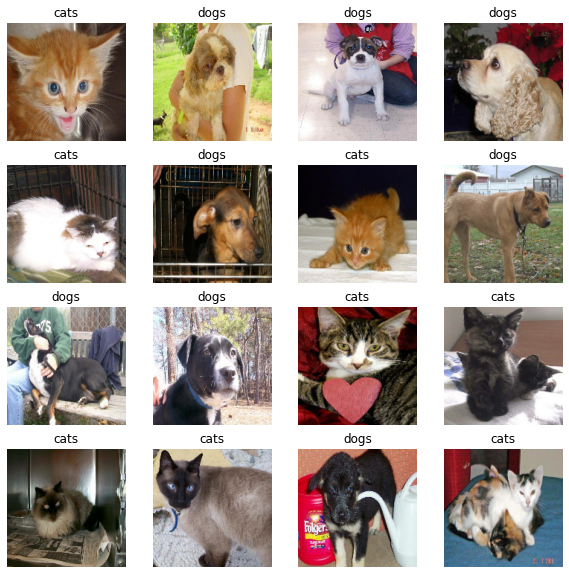

In [44]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
one_batch_prediction = model.predict_on_batch(image_batch).flatten() # return a numpy array of prediction that collapsed into one dimension

# apply a sigmoid since the model returns logits; sigmoid function is used to decide between two classes
one_batch_prediction = tf.nn.sigmoid(one_batch_prediction)
one_batch_prediction = tf.where(one_batch_prediction < 0.5, 0, 1)

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(class_names[one_batch_prediction[i]])
    plt.axis('off')
    
plt.show()

### Summary

- **Using a pre-trained model for feature extraction**: it is a common practice to take advantage of features learned by a model trained on a larger dataset compared to what we have (small dataset). The convolutional base model extracts features associated with each images and all we have to do is training a classifier on top of it which determines the image class (whether it is cat or dog) given that set of extracted features.

- **Fine-tuning a pre-trained model**: to improve better output results, fine-tuning the top-level layers of the pre-trained model is also applicable. In this case, we tuned our weights such that the model learned high-level features specific to the new dataset. 

In [ ]:
# MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.